In [2]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 32.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.2-cp37-cp37m-linux_x86_64.whl size=2183204 sha256=db750a042d8900cdcc27c34099c16515e9e9897528d449ac4ee85213e189ce46
  Stored in directory: /root/.cache/pip/wheels/62/d6/0a/91ea5f998589bc72ca3fcf425c0e364baf8536753e1cd26ea4
Successfully built mpi4py


In [8]:
%%writefile bif.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# if rank == 0:
#   start = MPI.Wtime()

NUM_OF_STEPS = 10000
INITIAL_STATE = 0.1
M = 1000
N = 500

r_list = np.linspace(1, 10, M)

def get_next_step(r, x):
    return r * x * (1. - x)

size_per_rank = int(M / size)

if rank == size - 1:
  size_per_rank += M % size
  l, r = rank * size_per_rank, M - 1
else:
  l, r = rank * size_per_rank, (rank + 1) * size_per_rank

data_part = np.empty([size_per_rank, M])

for index, r in enumerate(r_list[l: r]):
  x = [INITIAL_STATE]
  for _ in range(NUM_OF_STEPS):
      x.append(get_next_step(r, x[-1]))
      
  data_part[index] = x[N: N + M]

data = comm.gather((data_part, rank) if size > 1 else data_part, root=0)

# if rank == 0:
#   elapsed_time = MPI.Wtime() - start
#   with open('results.csv', 'a+') as f:
#     f.write(f'{size}, {elapsed_time}\n')

MPI.Finalize()

if rank == 0:
  print(f'{size} processes done')

if rank == 0:
  if size > 1:
    data.sort(key = lambda tup: tup[1])
    data = np.array(data)[:, :-1].squeeze()
    data = np.concatenate(data, axis=0)
  else:
    data = np.array(data).squeeze()
    
  fig, ax = plt.subplots(figsize=(15, 15))

  fig.set_facecolor('#846075')

  ax.axis([min(r_list), 5, 0, 1 + 0.1])
  ax.set_facecolor('#4A6C6F')

  ax.set_xlabel('r')
  ax.set_ylabel('population equlibrium')
  l, = ax.plot([], [], '.', color='#D7DEDC')

  t = [r * np.ones(data.shape[0]) for r in r_list]
  
  dir_name = 'pics'
  
  os.system(f'rm -rf {dir_name}')
  os.mkdir(dir_name)

  images = []

  for i, _ in enumerate(t):
      index = str(i).zfill(4)
      imgname = f'{dir_name}/bif_pic_{index}' 
      images.append(imgname)

      ax.scatter(t[:i], data[:i], c='white')
      plt.savefig(images[-1])

Overwriting bif.py


In [10]:
!mpirun --allow-run-as-root -n 30 python bif.py

30 processes done
(1000, 1000) [[0.00194555 0.00194177 0.001938   ... 0.00066134 0.00066091 0.00066047]
 [0.00901558 0.00901479 0.00901401 ... 0.00892858 0.00892858 0.00892858]
 [0.0177007  0.01770068 0.01770065 ... 0.01769912 0.01769912 0.01769912]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [62]:
# %%bash

# rm results.csv

# for i in {1..8}
# do
#   mpirun --allow-run-as-root -n $i python bif.py   
# done
# cat results.csv

1 processses done
2 processses done
3 processses done
4 processses done
5 processses done


In [6]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

In [11]:
!convert pics/* bif_map.gif

In [16]:
import matplotlib.pyplot as plt
import numpy as np

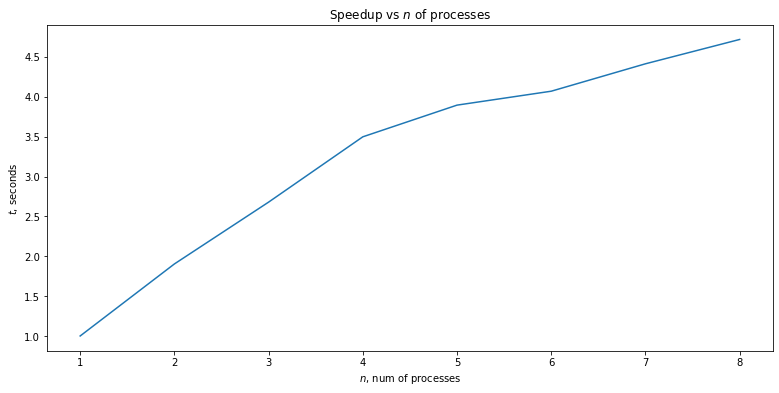

In [30]:
seq_time = None
time_list = []
size_list = []

with open('results.csv', 'r') as f:
  
  for row_id, line in enumerate(f.readlines()):
    data = line.split(',')
    size, time = np.float(data[0]), np.float(data[-1])
    if row_id == 0:
      seq_time = time

    time_list.append(time)
    size_list.append(size)
  

speedup_list = seq_time / np.array(time_list)

_, ax = plt.subplots(figsize=(13, 6))

ax.plot(size_list, speedup_list)

ax.set_title('Speedup vs $n$ of processes')
ax.set_ylabel('$t$, seconds')
ax.set_xlabel('$n$, num of processes')

plt.show()

### looks like our paralellizing approach does accelerates code execution, because we winess here approximately linear time dependecy on processes number

In [ ]:
from IPython.core.display import Image

In [1]:
Image(url='bif_map.gif')

NameError: ignored